# Figure 5

This jupyter-notebook contains the code for generating Figure 5 of the manuscript, which analyses the dispersal rate estimates from the SLiM simulation. The instructions to generate the datafiles used in this plot is given below.

In [1]:
import sparg as sparg
import tskit
import numpy as np
import matplotlib.pyplot as plt

def locate_nodes(nodes, SpARG):
    """Calculate the location of the list of nodes

    Parameters
    ----------
    nodes : list
        List of nodes for which the locations will be calculated
    SpARG : SpatialARG
    	An instance of the SpatialARG class defined below. 

    Returns
    -------
    node_locations : dict
        The keys are the nodes. The values are the geographic location of the nodes in n dimensions
    variance_in_node_locations : dict
        The keys are the nodes. The values are the variance in the geographic location of the nodes in n dimensions
    """

    sigma = SpARG.dispersal_rate_matrix
    paths = SpARG.paths
    inverted_cov_mat = SpARG.inverted_paths_shared_time_matrix
    sample_locs_to_root_locs = SpARG.path_dispersal_distances
    root_locations = SpARG.root_locations
    node_shared_times = SpARG.node_paths_shared_times
    node_paths = SpARG.node_paths
    ts = SpARG.ts
    
    location_of_nodes = {} 
    variance_in_node_locations = {} 
    
    for i,node in enumerate(nodes): 
        node_specific_sharing = node_shared_times[node,:].copy()
        matmul_prod = np.matmul(node_specific_sharing, inverted_cov_mat)
        root_location = root_locations[node_paths[node][-1]]
        node_location = root_location + np.matmul(matmul_prod, sample_locs_to_root_locs)
        location_of_nodes[node] = node_location
        
        base_variance = np.matmul(matmul_prod, np.transpose(node_specific_sharing))
        ones = np.ones(inverted_cov_mat.shape[0])
        correction_denominator = np.matmul(np.matmul(np.transpose(ones),inverted_cov_mat),ones)
        correction_numerator = (1-np.matmul(np.matmul(np.transpose(node_specific_sharing),inverted_cov_mat),ones))**2
        corrected_variance_scaling_factor = (ts.max_root_time-ts.node(node).time)-base_variance+(correction_numerator/correction_denominator)
        total_variance_node = sigma*corrected_variance_scaling_factor
        variance_in_node_locations[node] = total_variance_node
    return location_of_nodes, variance_in_node_locations



def average_dispersal_treewise(ts, locations_of_nodes):
    branch_lengths = ts.tables.nodes.time[ts.tables.edges.parent] - ts.tables.nodes.time[ts.tables.edges.child]
    child_locations = np.array(list( map(locations_of_nodes.get, ts.tables.edges.child) ))
    parent_locations = np.array(list( map(locations_of_nodes.get, ts.tables.edges.parent) ))
    branch_distances = parent_locations - child_locations 
    ts_trees = ts.aslist()
    dispersal_rate = []
    average_dispersal_rate = []
    for ts_tree in ts_trees:     
        edge_ind = ts_tree.edge_array[ts_tree.edge_array>-1]
        tree_branch_lengths = branch_lengths[edge_ind]
        tree_branch_distances = branch_distances[edge_ind]
        tree_dispersal_rate = [ np.matmul( np.transpose([tree_branch_distances[i]]),[tree_branch_distances[i]] )/tree_branch_lengths[i] for i in range(len(tree_branch_distances)) ]
        tree_dispersal_rate = np.sum(np.array(tree_dispersal_rate), axis=0)/ts.num_samples   
        dispersal_rate += [tree_dispersal_rate]
        average_dispersal_rate += [ np.average(np.array(dispersal_rate), axis=0) ]
    return dispersal_rate, average_dispersal_rate 

# Data File Generation Instructions 
All of the following files and those used to generate them can be found in folder DataFiles (which is in the same folder as this jupyter-notebook)

1. `slim_disp0.25_matingM_compCrepRsigma.trees` : These are the trees files used in Fig 5. They were obtained by running "simple_space.slim" on our cluster (UToronto, Scinet, Niagara) using the bash script "SLiM_Parallelize.sh".

2. `slim_disp0.25_matingM_compCrepRsigma.trees_output.txt` : These are the dispersal rate estimates plotted in Fig 5. They were obtained from the .trees files above above using the  "ComputingDispersalRates.py" on the cluster with bash script "ComputingDispersalRates.sh".

# Code to generate plots

## Code for panel A

In [2]:
# CODE TO GENERATE THE REALIZED DISPERSAL RATE from trees file

ts = tskit.load("./DataFiles/slim_disp0.25_mating1.0_comp1.0rep1sigma.trees")
sd = 1
np.random.seed(sd)
keep_nodes = list(np.random.choice(ts.samples(), 100, replace=False))
ts_sim, sim_map = ts.simplify(samples=keep_nodes, keep_input_roots=False, keep_unary=True, map_nodes=True)
ts_filtered, filtered_maps = sparg.simplify_with_recombination(ts=ts_sim)
ts_chopped = sparg.chop_arg(ts_sim,10000)
print(len(ts_chopped.tables.edges))

d = 0 
d_sqrt = 0
n = 0

unique_edges = np.unique(np.column_stack((ts_chopped.edges_child, ts_chopped.edges_parent)), axis=0)
child_individuals = ts_chopped.tables.nodes.individual[np.array(unique_edges[:,0]) ]
parent_individuals = ts_chopped.tables.nodes.individual[np.array(unique_edges[:,1]) ]

child_locations = ts_chopped.tables.individuals[child_individuals].location.reshape(len(unique_edges),3) 
parent_locations = ts_chopped.tables.individuals[parent_individuals].location.reshape(len(unique_edges),3)

child_times = ts_chopped.tables.nodes.time[unique_edges[:,0]]
parent_times = ts_chopped.tables.nodes.time[unique_edges[:,1]]

disp_x = np.sum((child_locations[:,0]-parent_locations[:,0])**2/([parent_times-child_times]),axis=1)/len(unique_edges)
disp_y = np.sum((child_locations[:,1]-parent_locations[:,1])**2/([parent_times-child_times]),axis=1)/len(unique_edges)

2371825


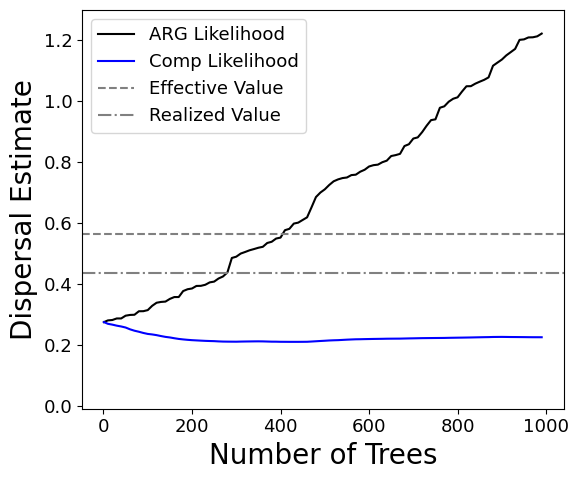

In [14]:
## CODE TO GENERATE THE PLOT

%matplotlib inline

dispersal_1 = np.loadtxt("./DataFiles/slim_disp0.25_mating1.0_comp1.0rep1sigma.trees_output.txt")
plt.figure(figsize=(5.9,4.9))
plt.plot(dispersal_1[:100,0], dispersal_1[:100,2], color='black', label = "ARG Likelihood")
plt.plot(dispersal_1[:100,0], dispersal_1[:100,5], color = 'blue', label = "Comp Likelihood")

plt.axhline(y=0.25**2+0.5,label = "Effective Value", linestyle = '--', color = 'grey')
plt.axhline(y=disp_x,label = "Realized Value", linestyle = '-.', color = 'grey')
plt.ylim((-0.01,1.25))

plt.legend(fontsize=13)
plt.xlabel("Number of Trees", fontsize = 20)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel("Dispersal Estimate", fontsize = 20)
plt.ylim((-0.01,1.3))
plt.tight_layout()
plt.savefig('DispRateFinal.png', format='png')
plt.show()

### Code for panels B and C

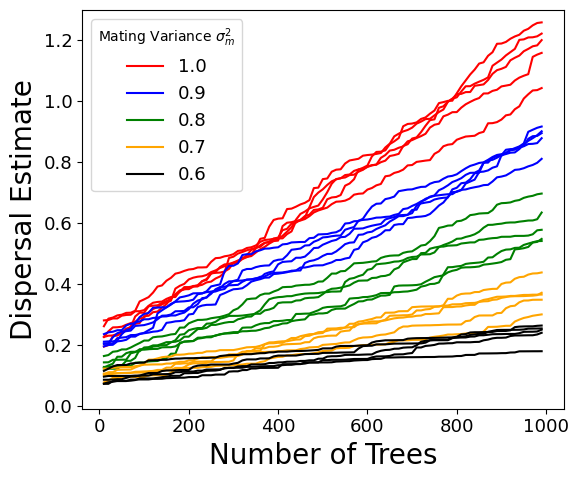

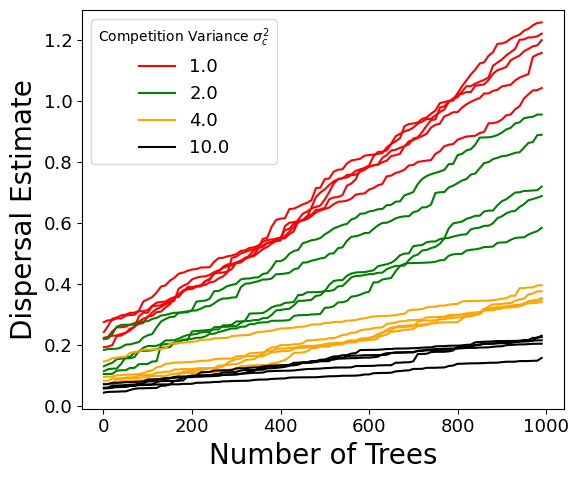

In [11]:
%matplotlib inline
#fig, ax = plt.subplots(2,1,figsize=(5.9,9.8))

plt.figure(figsize=(5.9,4.9))

colors = ["red","blue", "green", "orange","black"]
i = 0 

comp=1.0

for mating in [1.0,0.9,0.8,0.7,0.6]:
    mating = round(mating,2)
    for rep in range(1,6):
        fname = "./DataFiles/slim_disp0.25" +"_mating"+str(mating)+"_comp"+str(comp)+ "rep"+str(rep)+ "sigma.trees"
        dispersal_1 = np.loadtxt(fname+"_output.txt")
        if rep == 1 : 
            plt.plot(dispersal_1[1:100,0], dispersal_1[1:100,2], label = str(mating), color = colors[i])
        else: 
            plt.plot(dispersal_1[1:100,0], dispersal_1[1:100,2], color = colors[i])
            
    i += 1

plt.legend(fontsize=13, title = r"Mating Variance $\sigma^2_m$")
plt.ylim((-0.01,1.3))
plt.xlabel("Number of Trees", fontsize = 20)
plt.ylabel("Dispersal Estimate", fontsize = 20)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
plt.savefig('DispRateMating.png', format='png')
plt.savefig('DispRateMating.svg', format='svg')

#plt.show()


plt.figure(figsize=(5.9,4.9))
colors = ["red", "green", "orange","black","pink","grey","purple","brown","silver"]
i = 0 

mating=1.0
for comp in [1.0, 2.0, 4.0, 10.0]:
    i += 1
    comp = round(comp,2)
    for rep in range(1,6):
        fname = "./DataFiles/slim_disp0.25" +"_mating"+str(mating)+"_comp"+str(comp)+ "rep"+str(rep)+ "sigma.trees"
        dispersal_1 = np.loadtxt(fname+"_output.txt")
            
        if rep == 1: 
            plt.plot(dispersal_1[0:100,0], dispersal_1[0:100,2], label = str(comp), color = colors[i-1])
        else: 
            plt.plot(dispersal_1[0:100,0], dispersal_1[0:100,2], color = colors[i-1])
        

plt.legend(fontsize=13, title = r"Competition Variance $\sigma^2_c$")
plt.ylim((-0.01,1.3))
plt.xlabel("Number of Trees", fontsize = 20)
plt.ylabel("Dispersal Estimate", fontsize = 20)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
# plt.savefig('DispRateComp.png', format='png')
# plt.savefig('DispRateComp.svg', format='svg')
plt.show()

## Code for panel D

In [15]:
# sample locations from trees file

ts = tskit.load("./DataFiles/slim_disp0.25_mating1.0_comp1.0rep1sigma.trees")
np.random.seed(1)
nsamples = 100
keep_nodes = list(np.random.choice(ts.samples(),nsamples, replace=False))

#FULL ARG
ts_sim, sim_map = ts.simplify(samples=keep_nodes, keep_input_roots=False, keep_unary=True, map_nodes=True)
ts_filtered, filtered_maps = sparg.simplify_with_recombination(ts=ts_sim)
ts_chopped = sparg.chop_arg(ts_filtered,1000)
FullARG = sparg.SpatialARG(ts=ts_chopped, dimensions=2, verbose=False)
#print(ts_chopped.draw_text())
path_matrix = FullARG.paths_shared_time_matrix
P = np.zeros((len(path_matrix), nsamples))
for path_id, path in enumerate(FullARG.paths) : 
    P[path_id][path[0]] = 1 
inverted_paths_matrix = FullARG.inverted_paths_shared_time_matrix
inverse_sample_covariance_matrix = np.matmul(np.matmul(np.transpose(P),inverted_paths_matrix),P)

R = FullARG.roots_array
RP = np.matmul(np.matmul(np.transpose(P),inverted_paths_matrix),R)


sigma_squared = np.array([[0.5625,0.0],[0.0,0.5625]])
sample_covariance_matrix = np.kron(np.linalg.inv(inverse_sample_covariance_matrix),sigma_squared)

sample_locations = np.matmul(np.linalg.inv(inverse_sample_covariance_matrix), np.matmul(RP,np.array(list(FullARG.root_locations.values())))).reshape(1,200)[0]
simulated = np.random.multivariate_normal(mean = sample_locations, cov =sample_covariance_matrix )


#SINGLE TREE
breakpts = ts_chopped.breakpoints(as_array=True)
bp = breakpts[1]
ts_short = ts_chopped.keep_intervals(intervals=[(0,bp)], simplify=False).trim()
ts_short_sim, maps_short_sim = sparg.simplify_with_recombination(ts=ts_short)
ShortARG = sparg.SpatialARG(ts=ts_short_sim, dimensions=2, verbose=False)

path_matrix = ShortARG.paths_shared_time_matrix
P = np.zeros((len(path_matrix), nsamples))
for path_id, path in enumerate(ShortARG.paths) : 
    P[path_id][path[0]] = 1 
inverted_paths_matrix = ShortARG.inverted_paths_shared_time_matrix
inverse_sample_covariance_matrix = np.matmul(np.matmul(np.transpose(P),inverted_paths_matrix),P)

R = ShortARG.roots_array
RP = np.matmul(np.matmul(np.transpose(P),inverted_paths_matrix),R)

sigma_squared = np.array([[0.5625,0.0],[0.0,0.5625]])
sample_covariance_matrix = np.kron(np.linalg.inv(inverse_sample_covariance_matrix),sigma_squared)

sample_locations = np.matmul(np.linalg.inv(inverse_sample_covariance_matrix), np.matmul(RP,np.array(list(ShortARG.root_locations.values())))).reshape(1,200)[0]
short_simulated = np.random.multivariate_normal(mean = sample_locations, cov =sample_covariance_matrix )

#PARTIAL ARG
breakpts = ts_chopped.breakpoints(as_array=True)
bp = breakpts[ int(len(breakpts)/2) ]
bp = breakpts[400]
ts_med = ts_chopped.keep_intervals(intervals=[(0,bp)], simplify=False).trim()
ts_med_sim, maps_med_sim = sparg.simplify_with_recombination(ts=ts_med)
MedARG = sparg.SpatialARG(ts=ts_med_sim, dimensions=2, verbose=False)

path_matrix = MedARG.paths_shared_time_matrix
P = np.zeros((len(path_matrix), nsamples))
for path_id, path in enumerate(MedARG.paths) : 
    P[path_id][path[0]] = 1 
inverted_paths_matrix = MedARG.inverted_paths_shared_time_matrix
inverse_sample_covariance_matrix = np.matmul(np.matmul(np.transpose(P),inverted_paths_matrix),P)

R = MedARG.roots_array
RP = np.matmul(np.matmul(np.transpose(P),inverted_paths_matrix),R)

sigma_squared = np.array([[0.5625,0.0],[0.0,0.5625]])
sample_covariance_matrix = np.kron(np.linalg.inv(inverse_sample_covariance_matrix),sigma_squared)

sample_locations = np.matmul(np.linalg.inv(inverse_sample_covariance_matrix), np.matmul(RP,np.array(list(MedARG.root_locations.values())))).reshape(1,200)[0]
med_simulated = np.random.multivariate_normal(mean = sample_locations, cov =sample_covariance_matrix )

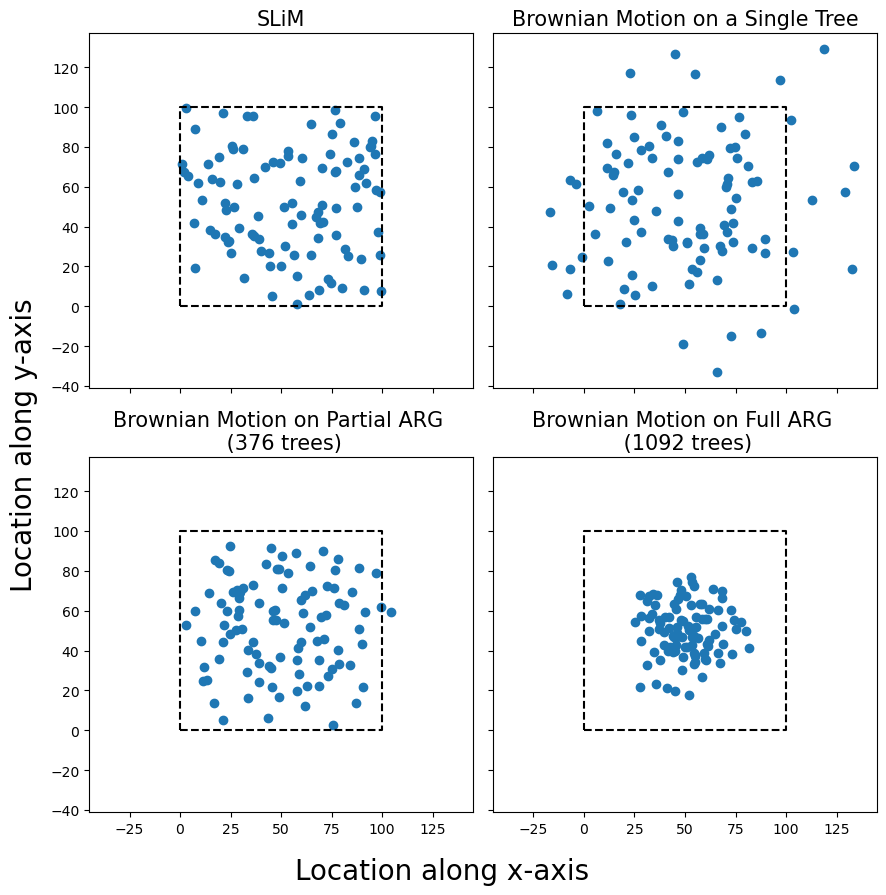

In [16]:
# make the plot

fig, ax = plt.subplots(2,2,sharex=True, sharey=True, figsize=(9,9))

ax[0][1].scatter(short_simulated[0:nsamples],short_simulated[nsamples:])
ax[0][1].plot([0,100,100,0,0],[0,0,100,100,0],linestyle = '--', color = 'black')

ax[0][1].set_title("Brownian Motion on a Single Tree", fontsize=15)
#ax[0][1].set_ylabel("Location along y-axis", fontsize = 20)

sim_locs = ts_chopped.tables.individuals[ts_chopped.tables.nodes.individual[np.where(ts_chopped.tables.nodes.flags == 1)[0]]].location
ax[0][0].scatter(sim_locs[::3],sim_locs[1::3])
ax[0][0].set_title("SLiM", fontsize=15)
ax[0][0].plot([0,100,100,0,0],[0,0,100,100,0],linestyle = '--', color = 'black')

ax[1][0].scatter(med_simulated[0:nsamples],med_simulated[nsamples:])
PartialARG_treecount = len(ts_med_sim.trees())
ax[1][0].set_title("Brownian Motion on Partial ARG \n ("+str(PartialARG_treecount)+" trees)", fontsize=15)
ax[1][0].plot([0,100,100,0,0],[0,0,100,100,0],linestyle = '--', color = 'black')
#ax[1][0].set_xlabel("Location along x-axis", fontsize = 20)

ax[1][1].scatter(simulated[0:nsamples],simulated[nsamples:])
FullARG_treecount = len(ts_chopped.trees())
ax[1][1].set_title("Brownian Motion on Full ARG \n ("+str(FullARG_treecount)+" trees)", fontsize=15)
ax[1][1].plot([0,100,100,0,0],[0,0,100,100,0],linestyle = '--', color = 'black')
#ax[1][1].set_xlabel("Location along x-axis", fontsize = 20)

fig.supxlabel("Location along x-axis", fontsize = 20)
fig.supylabel("Location along y-axis", fontsize = 20)
plt.xlim((-45,145))
plt.tight_layout()
plt.savefig("DispPattern.svg",format='svg')
plt.savefig("DispPattern.png",format='png')